# Interactive UMAP & HDBSCAN Clustering Pipeline

This notebook allows you to run the clustering pipeline step-by-step with adjustable parameters.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

from umap_hdbscan_pipeline import * # Importing the custom pipeline for UMAP and HDBSCAN


## Load Data and Parameters Configuration
Set your CSV file paths below. Together with binning interval lenghts (in seconds). Parameters for UMAP and HDBSCAN should be altered based on yor data density and amount of sampeles - play around with it 😉

In [19]:
# Edit paths here

DATA_PATH_FEMALES = "/Users/veronika/ownCloud/PCA_analysis2025/SocialOF/HFD/females/atg7KO/Social/master_combined_females_atg7KO_HFD_SocialOF_FINAL.csv" #path/to/females.csv"
DATA_PATH_MALES = "/Users/veronika/ownCloud/PCA_analysis2025/SocialOF/HFD/males/atg7KO/master_combined_males_atg7KO_HFD_SocialOF_FINAL.csv"  #"path/to/males.csv"

In [20]:
#Binning interval length in seconds - can be altered based on your data
#This is the length of the time window for which the data will be aggregated
INTERVAL_LENGTH_SEC = 2

In [21]:
# Defining behavioural columns - these are by default set to social OF (without W animal) - needs to be adjusted for Single OF
behavior_cols = [
    'B_W_nose2nose', 'B_W_sidebyside', 'B_W_sidereside', 'B_W_nose2tail', 'B_W_nose2body',
    'B_W_following', 'B_climb-arena', 'B_sniff-arena', 'B_immobility', 'B_stat-lookaround',
    'B_stat-active', 'B_stat-passive', 'B_moving', 'B_sniffing', 'B_speed'
]

In [22]:
UMAP_PARAMS = dict(
    n_components=2,
    n_neighbors=25,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    verbose=True,
)

In [23]:
HDBSCAN_PARAMS = dict(
    min_cluster_size=500,
    min_samples=90,
    gen_min_span_tree=True  # <-- Enable MST generation for DBCV calculation
)

## Data pre-processing

In [24]:
# Load and combine data
combined_df = load_and_combine_data(DATA_PATH_FEMALES, DATA_PATH_MALES)
print("Data loaded, first few rows:")
display(combined_df.head())

Data loaded, first few rows:


,Time,B_W_nose2nose,B_W_sidebyside,B_W_sidereside,B_W_nose2tail,B_W_nose2body,B_W_following,B_climb-arena,B_sniff-arena,B_immobility,...,B_stat-active,B_stat-passive,B_moving,B_sniffing,B_speed,B_missing,W_missing,experimental_id,Geno,Sex
0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ID198,atg7KO,Female
1,0 days 00:00:00.066614855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ID198,atg7KO,Female
2,0 days 00:00:00.133229710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ID198,atg7KO,Female
3,0 days 00:00:00.199844565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ID198,atg7KO,Female
4,0 days 00:00:00.266459420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,87.002397,0.0,0.0,ID198,atg7KO,Female


In [25]:
# Create intervals
combined_df = create_intervals(combined_df, INTERVAL_LENGTH_SEC)
print("Intervals created:")
display(combined_df[['Time', 'Interval_label']].head())

Intervals created:


,Time,Interval_label
0,0 days 00:00:00,0 days 00:00:00 - 0 days 00:00:02
1,0 days 00:00:00.066614855,0 days 00:00:00 - 0 days 00:00:02
2,0 days 00:00:00.133229710,0 days 00:00:00 - 0 days 00:00:02
3,0 days 00:00:00.199844565,0 days 00:00:00 - 0 days 00:00:02
4,0 days 00:00:00.266459420,0 days 00:00:00 - 0 days 00:00:02


In [26]:
# Aggregate behaviors
agg_df = aggregate_behaviors(combined_df, behavior_cols)
print("Aggregated behaviors:")
display(agg_df.head())

Aggregated behaviors:


,Interval_bin,Interval_label,Sex,experimental_id,Geno,B_W_nose2nose,B_W_sidebyside,B_W_sidereside,B_W_nose2tail,B_W_nose2body,B_W_following,B_climb-arena,B_sniff-arena,B_immobility,B_stat-lookaround,B_stat-active,B_stat-passive,B_moving,B_sniffing,B_speed
0,0,0 days 00:00:00 - 0 days 00:00:02,Female,ID196,atg7KO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387097,0.0,0.000000,0.000000,0.354839,0.516129,0.064516,105.206360
1,0,0 days 00:00:00 - 0 days 00:00:02,Female,ID198,atg7KO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.870968,0.129032,103.261293
2,0,0 days 00:00:00 - 0 days 00:00:02,Female,ID200,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.451613,0.000000,0.000000,0.870968,0.225806,63.985375
3,0,0 days 00:00:00 - 0 days 00:00:02,Female,ID202,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193548,0.0,0.000000,0.774194,0.000000,0.096774,0.548387,32.443262
4,0,0 days 00:00:00 - 0 days 00:00:02,Female,ID204,atg7KO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.354839,0.000000,0.516129,0.064516,98.379995


# Parameters
adjust before running the pipeline

In [27]:
# Filtering your data and impute missing data
filtered_df, behavior_cols_filtered = preprocess_and_impute(
    agg_df,
    exclude_ids=['ID63', 'ID214'], # Exclude specific IDs - if nothing to exclude, set to empty list or comment out
    exclude_geno='atg7OE', # Exclude specific genotype - if nothing to exclude, set to empty list or comment out
    last_label="0 days 00:09:58 - 0 days 00:10:00" # Last interval label to keep
)
print("Data after filtering and imputation:")
display(filtered_df.head())

Data after filtering and imputation:


,Interval_bin,Interval_label,Sex,experimental_id,Geno,B_W_nose2nose,B_W_sidebyside,B_W_sidereside,B_W_nose2tail,B_W_nose2body,B_W_following,B_climb-arena,B_sniff-arena,B_immobility,B_stat-lookaround,B_stat-active,B_stat-passive,B_moving,B_sniffing,B_speed
0,0,0 days 00:00:00 - 0 days 00:00:02,Male,ID13,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.521739,0.000000,0.217391,0.608696,0.217391,42.759783
1,1,0 days 00:00:02 - 0 days 00:00:04,Male,ID13,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.766667,0.000000,0.000000,0.433333,0.566667,0.033333,63.985500
2,2,0 days 00:00:04 - 0 days 00:00:06,Male,ID13,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233333,0.866667,0.000000,0.000000,0.800000,0.200000,0.166667,11.509500
3,3,0 days 00:00:06 - 0 days 00:00:08,Male,ID13,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.800000,0.000000,0.000000,0.600000,0.400000,0.300000,25.641500
4,4,0 days 00:00:08 - 0 days 00:00:10,Male,ID13,control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.000000,0.000000,0.333333,0.000000,0.666667,0.200000,76.308500


In [28]:
# Scaling of features
scaled_data = scale_features(filtered_df, behavior_cols_filtered)

## Run the Clustering Pipeline

In [29]:
#Compute UMAP embedding
embedding = compute_umap_embedding(scaled_data, UMAP_PARAMS)
filtered_df['UMAP_1'] = embedding[:, 0]
filtered_df['UMAP_2'] = embedding[:, 1]

print("UMAP embedding added")

UMAP(n_jobs=1, n_neighbors=25, random_state=42, verbose=True)
Thu Aug  7 14:16:40 2025 Construct fuzzy simplicial set
Thu Aug  7 14:16:40 2025 Finding Nearest Neighbors
Thu Aug  7 14:16:40 2025 Building RP forest with 10 trees
Thu Aug  7 14:16:40 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu Aug  7 14:16:41 2025 Finished Nearest Neighbor Search
Thu Aug  7 14:16:41 2025 Construct embedding


Epochs completed:   2%| ▏          11/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         61/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  22%| ██▏        111/500 [00:02]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       161/500 [00:03]

	completed  150  /  500 epochs


Epochs completed:  42%| ████▏      211/500 [00:04]

	completed  200  /  500 epochs


Epochs completed:  52%| █████▏     261/500 [00:05]

	completed  250  /  500 epochs


Epochs completed:  62%| ██████▏    311/500 [00:06]

	completed  300  /  500 epochs


Epochs completed:  72%| ███████▏   361/500 [00:07]

	completed  350  /  500 epochs


Epochs completed:  82%| ████████▏  411/500 [00:08]

	completed  400  /  500 epochs


Epochs completed:  92%| █████████▏ 461/500 [00:09]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:10]

Thu Aug  7 14:16:52 2025 Finished embedding
UMAP embedding added


In [30]:
# Perform HDBSCAN clustering - the -1 cluster is noise
labels, clusterer = perform_hdbscan_clustering(embedding, HDBSCAN_PARAMS)
filtered_df = add_cluster_labels(filtered_df, labels)
print("Clustering done, cluster label counts:")
display(filtered_df['Cluster'].value_counts())

Clustering done, cluster label counts:


Cluster
 0    2355
 3    1655
-1    1363
 2    1349
 5    1036
 4     968
 1     951
Name: count, dtype: int64

# Cluster assessment

In [31]:
# Assess cluster quality
assess_cluster_quality(clusterer, embedding)

Cluster persistence scores: [0.46279013 0.47319584 0.42696607 0.40556046 0.19620218 0.29959647]
Silhouette Score (excluding noise): 0.5126
Davies-Bouldin Index (excluding noise): 0.8060 (lower is better)
Calinski-Harabasz Index (excluding noise): 13310.2217 (higher is better)
HDBSCAN DBCV (relative_validity_): 0.1442


array([0.46279013, 0.47319584, 0.42696607, 0.40556046, 0.19620218,
       0.29959647])

In [32]:
# Perform statistical tests (Kruskal-Wallis and Dunn's) - can be tested for normality first, but here we assume non-normality
kruskal_results, dunn_results = perform_stat_tests(filtered_df, behavior_cols_filtered)

Performing Kruskal-Wallis and Dunn's tests:
Kruskal-Wallis for B_W_nose2nose: stat=2732.650, p=0.0000
Dunn's test results for B_W_nose2nose:
               0              1              2    3              4  \
0   1.000000e+00  8.253911e-247  7.894699e-272  0.0  6.624066e-243   
1  8.253911e-247   1.000000e+00   6.066536e-01  1.0   1.000000e+00   
2  7.894699e-272   6.066536e-01   1.000000e+00  1.0   1.000000e+00   
3   0.000000e+00   1.000000e+00   1.000000e+00  1.0   1.000000e+00   
4  6.624066e-243   1.000000e+00   1.000000e+00  1.0   1.000000e+00   
5  5.501525e-277   1.000000e+00   4.303276e-02  1.0   1.000000e+00   

               5  
0  5.501525e-277  
1   1.000000e+00  
2   4.303276e-02  
3   1.000000e+00  
4   1.000000e+00  
5   1.000000e+00  

Kruskal-Wallis for B_W_sidebyside: stat=82.061, p=0.0000
Dunn's test results for B_W_sidebyside:
              0             1             2             3             4  \
0  1.000000e+00  9.779053e-08  9.904674e-10  4.138655e-10  7.8

# Plotting of Clustering

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


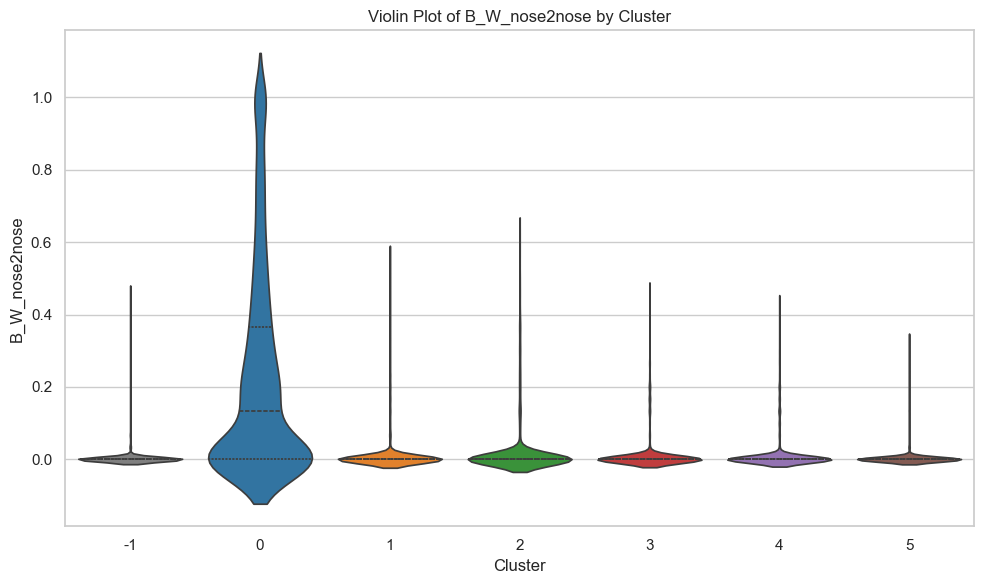

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


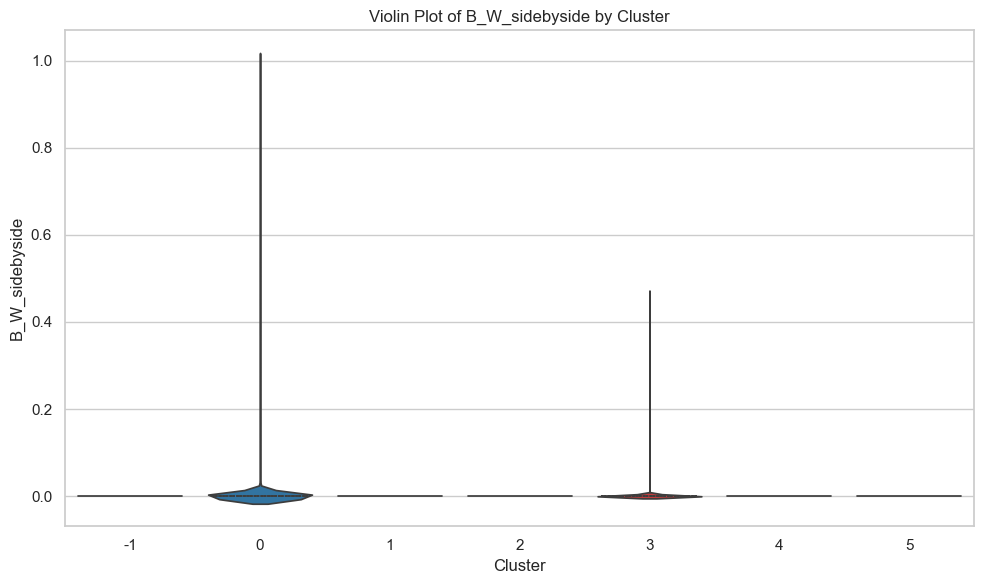

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


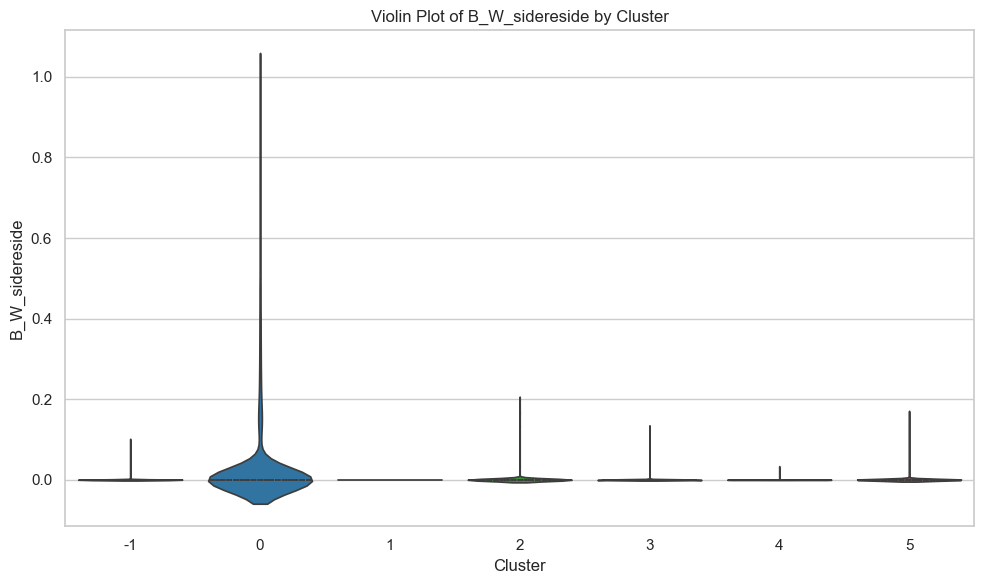

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


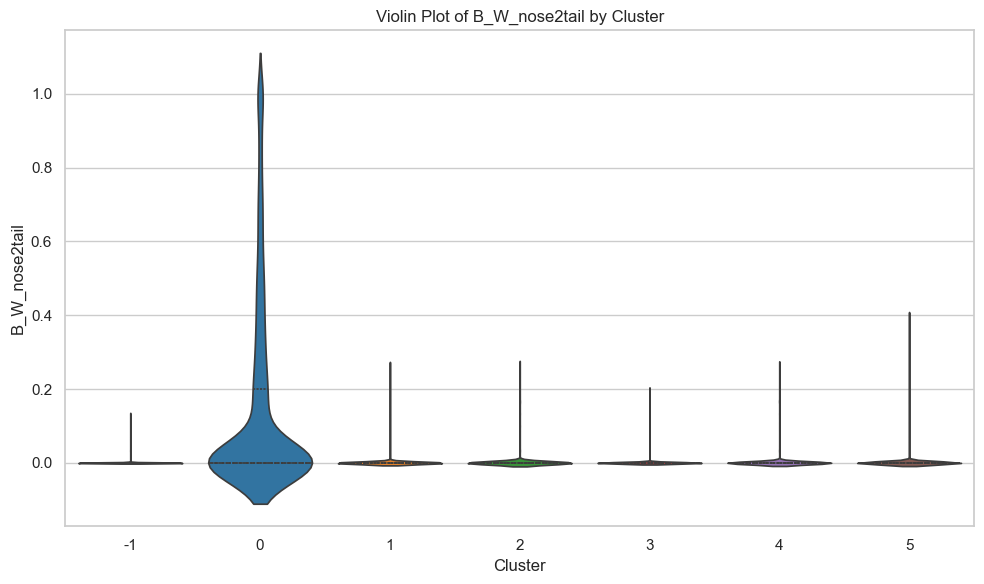

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


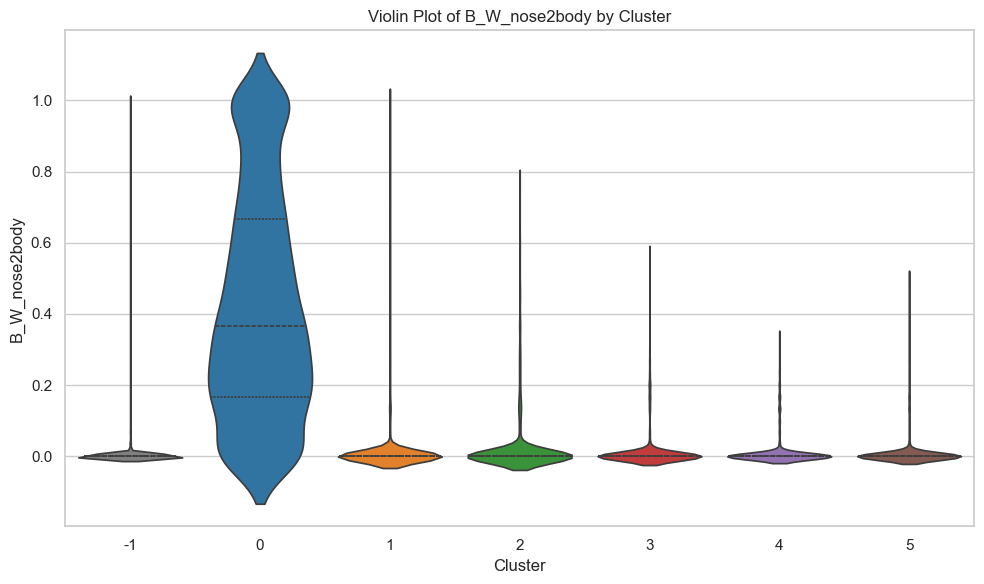

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


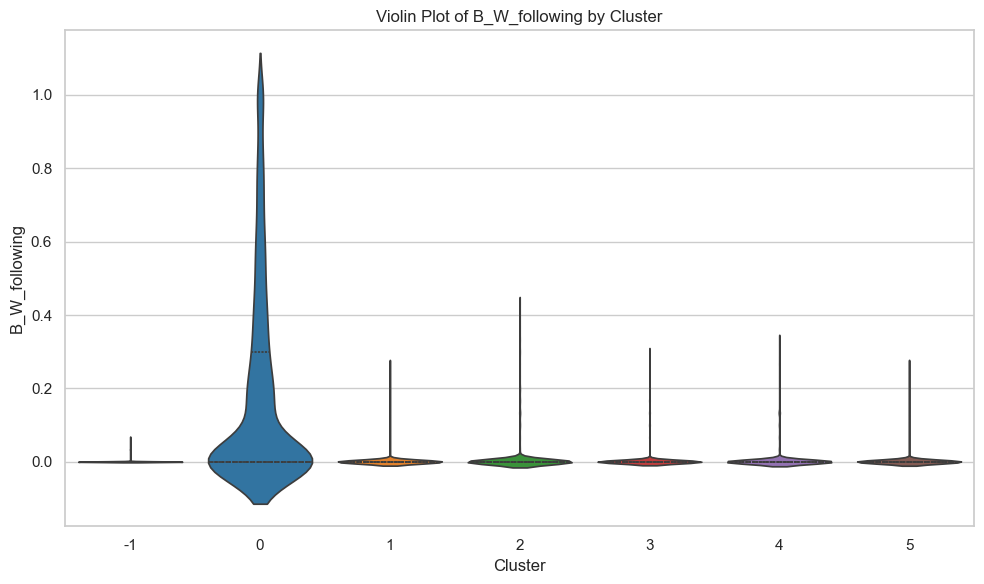

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


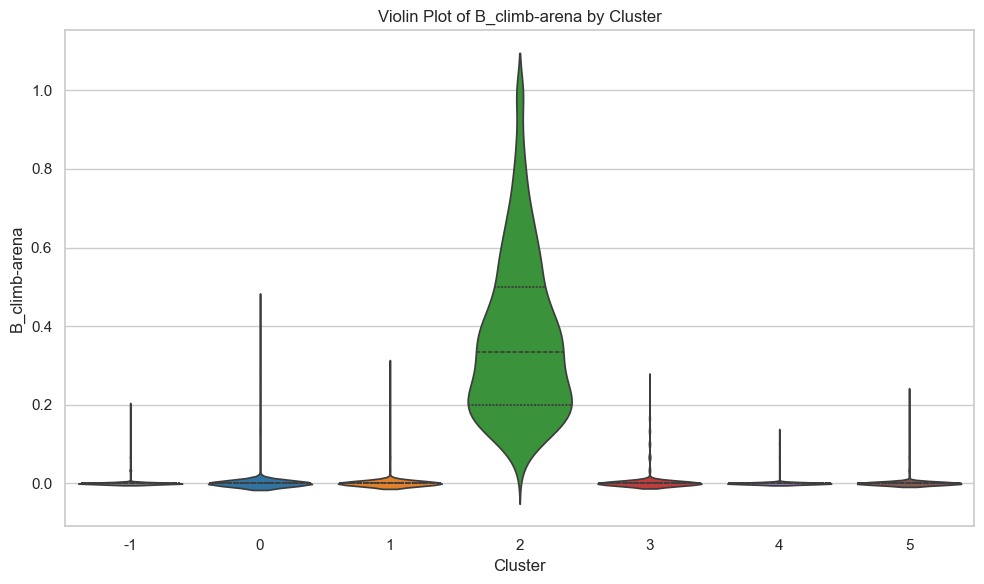

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


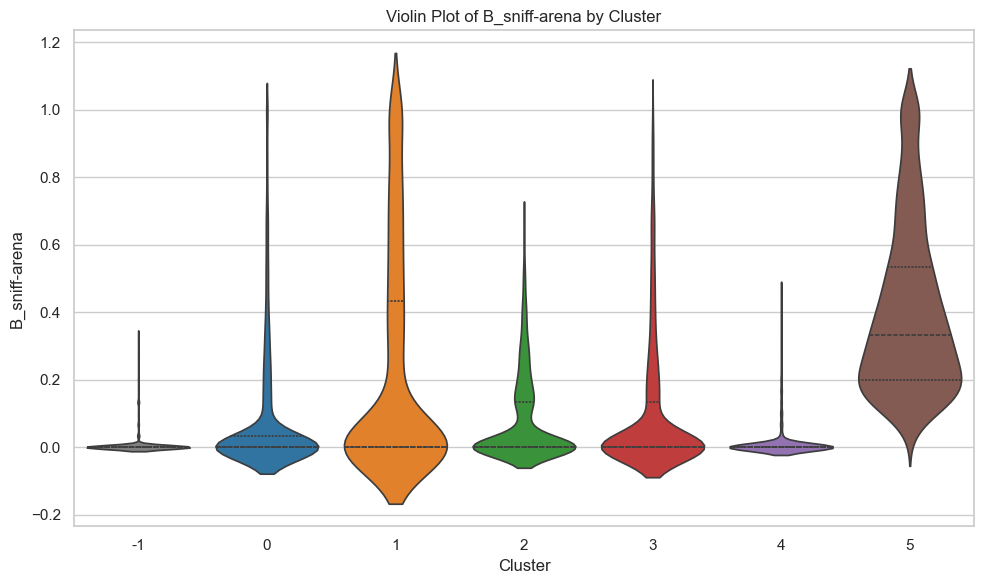

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


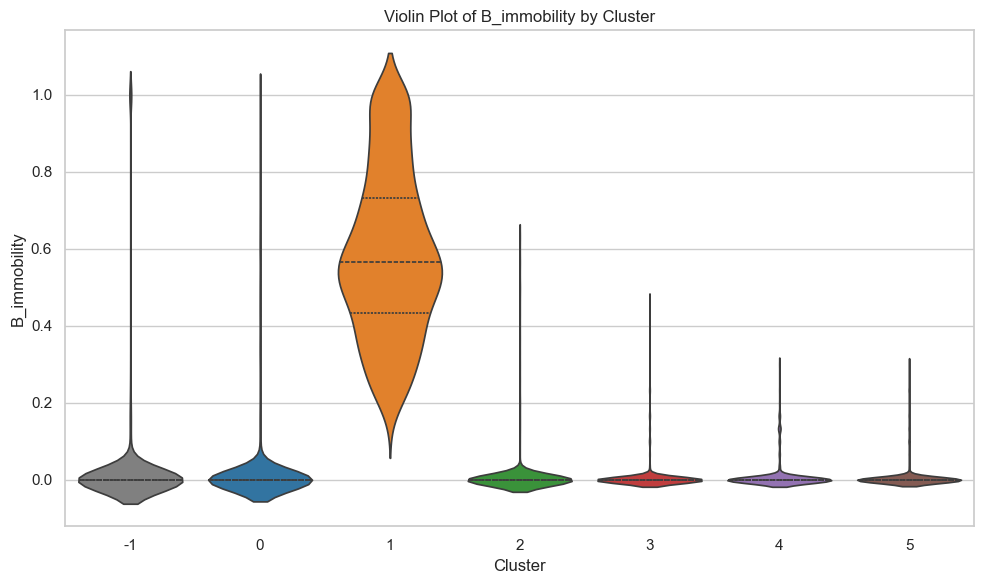

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


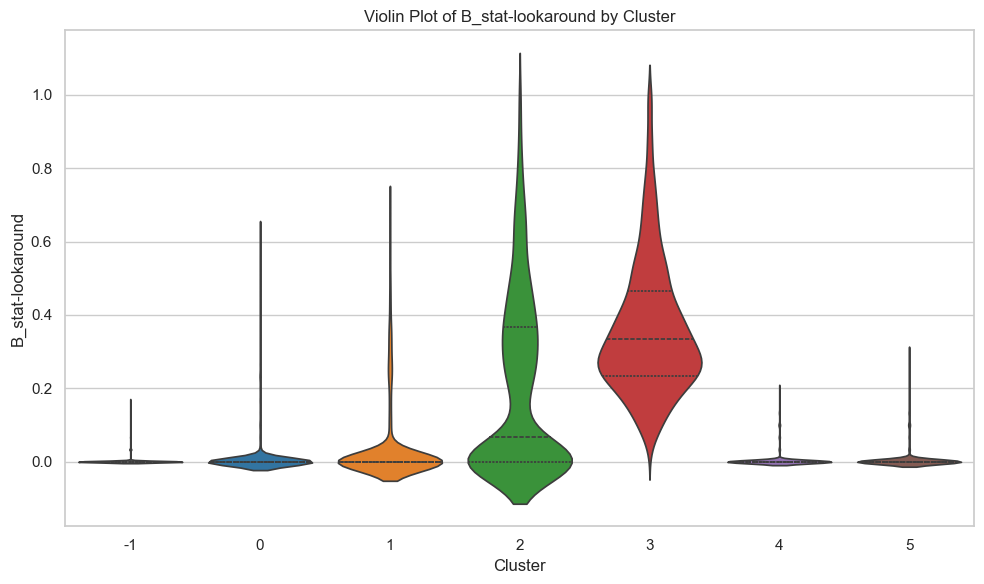

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


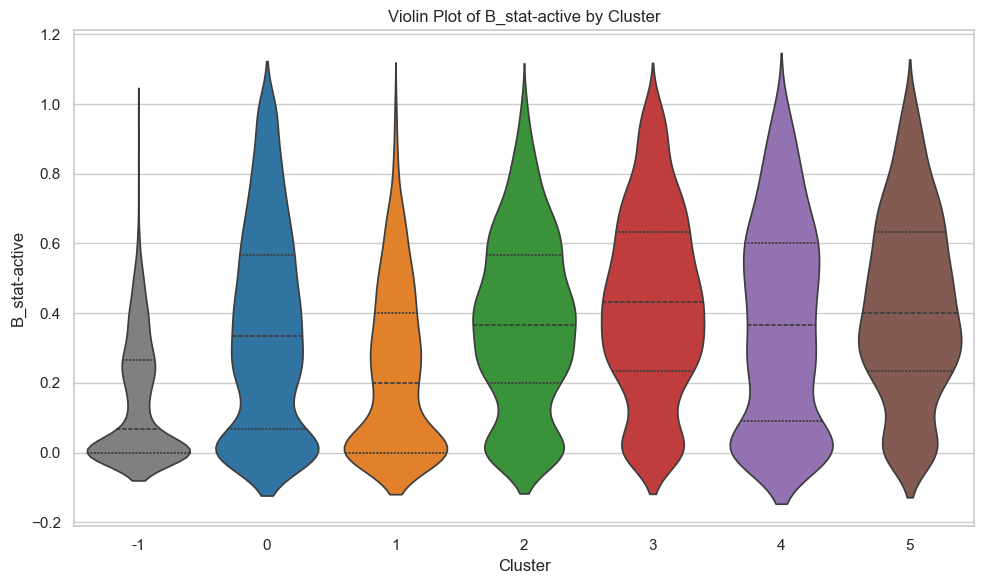

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


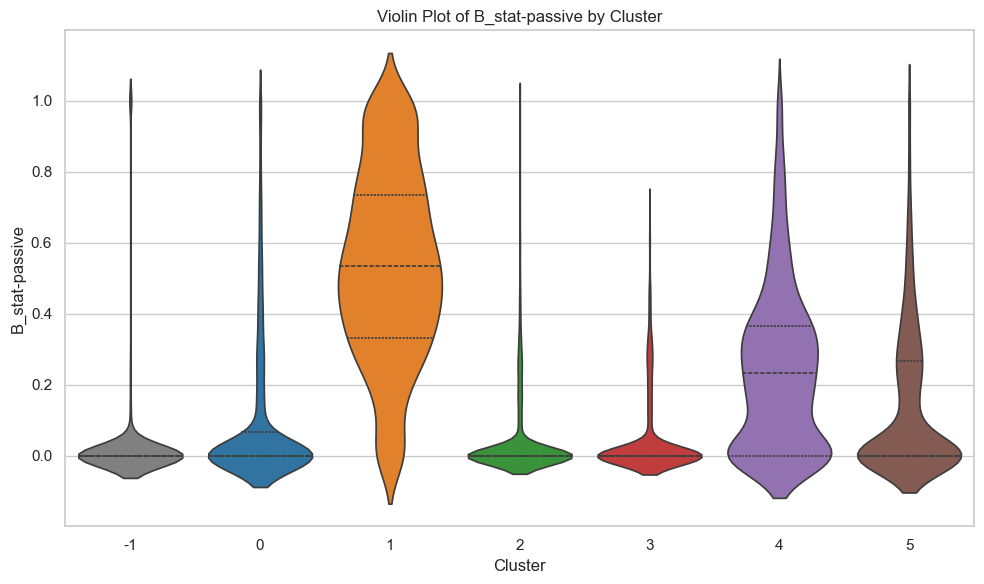

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


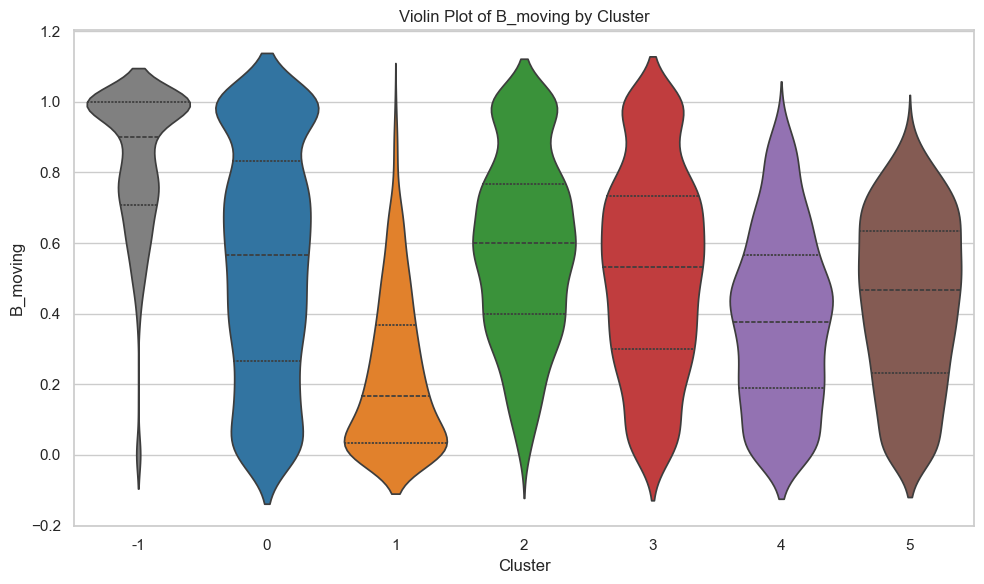

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


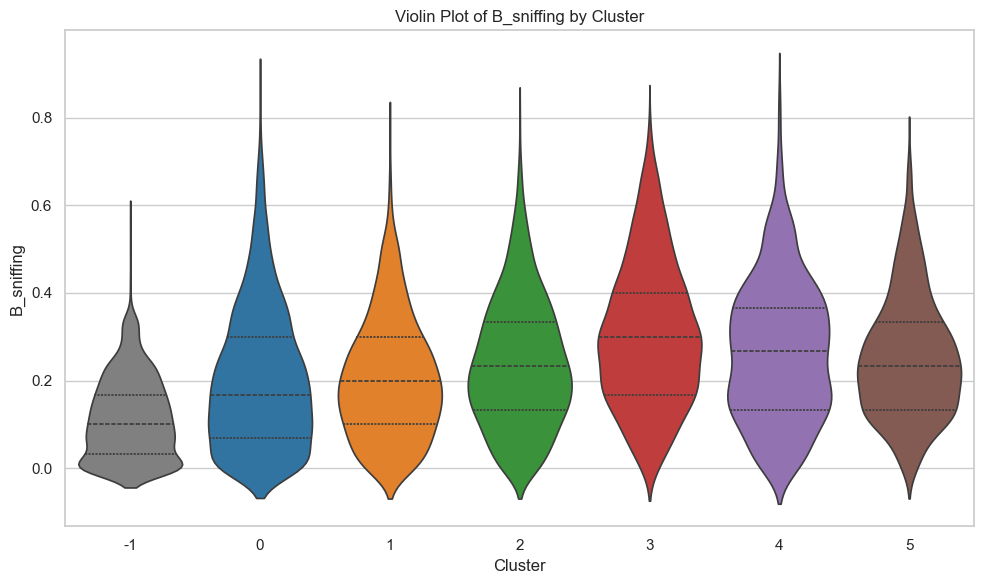

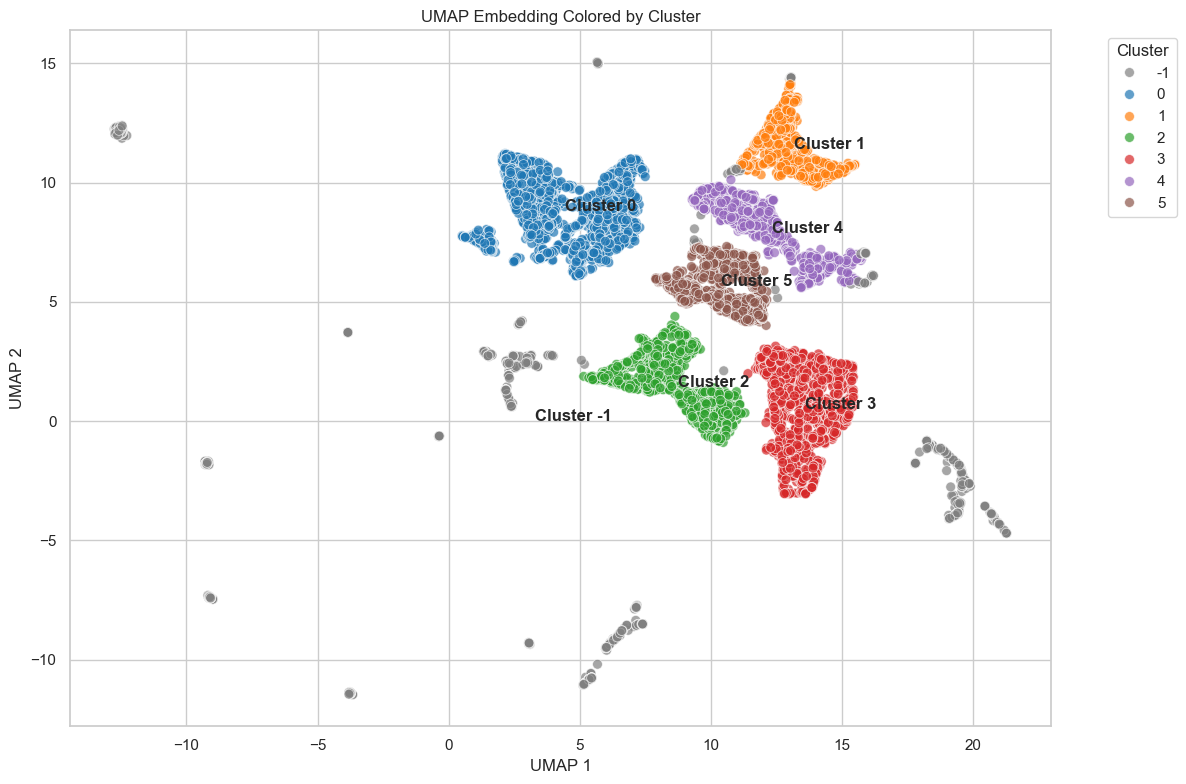

posx and posy should be finite values
posx and posy should be finite values


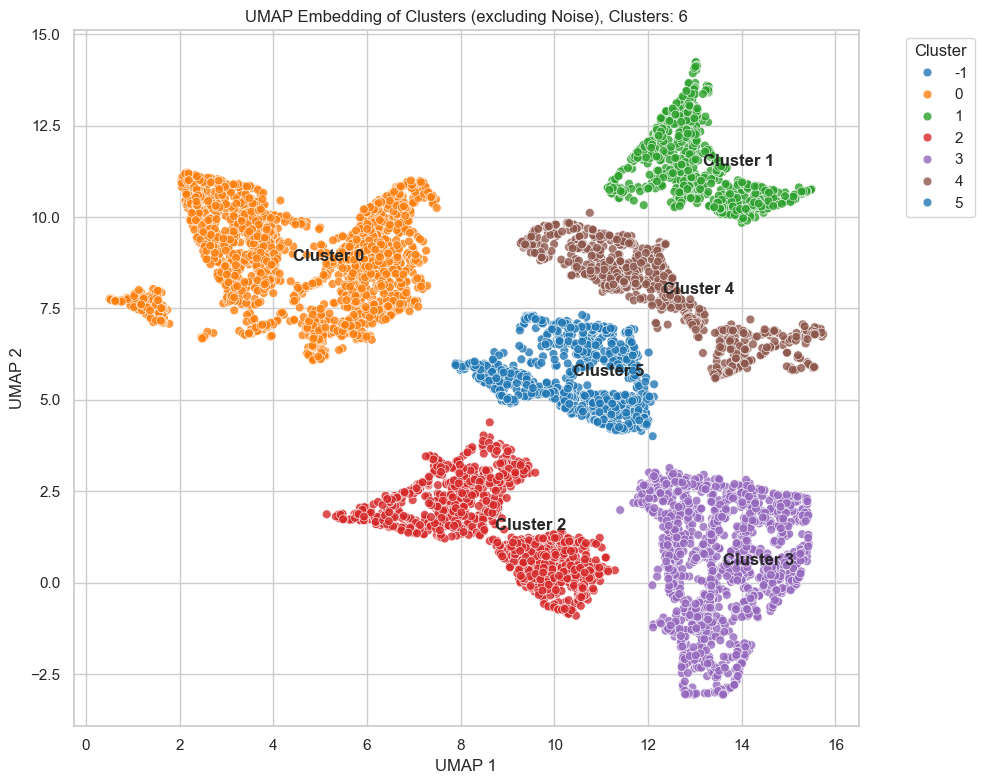

In [33]:
# Plot clustered behavioral profiles (violin + scatter)
plot_cluster_profiles(filtered_df, behavior_cols_filtered)
# To plot clusters excluding noise:
plot_clusters_without_noise(filtered_df)

## Save Results (optional)

In [34]:
#output_csv_path = 'clustered_results.csv'
#filtered_df.to_csv(output_csv_path, index=False)
#print(f'Saved clustered results to {output_csv_path}')